# **Megfelelő modulok telepítése, beimportálása**

In [ ]:
!pip install transformers==4.28.0
!pip install torch
!pip install newsapi-python
!pip install wordcloud
!pip install matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 33.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 102.4 MB/s eta 0:00:00
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.15.0
    Uninstalling tokenizers-0.15.0:
      Successfully uninstalled tokenizers-0.15.0
  Attempting uninstall: transformers
    Found existing installation: transformers 4.35.2
    Uninstalling transformers-4.35.2:
      Successfully uninstalled transformers-4.35.2


In [ ]:
from newsapi import NewsApiClient
import json
from transformers import AutoModelForSequenceClassification, AutoTokenizer, Trainer, TrainingArguments
import numpy as np
from scipy.special import expit
import torch
from transformers import RobertaTokenizer, RobertaForSequenceClassification
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# **Adatok kinyerésse a News API web-API-ból, megfelelő adattípusban**

In [ ]:
News_API_Key='f64473df75824d5ab4f6f496044bc350'

newsapi = NewsApiClient(News_API_Key)

In [ ]:
top_headlines = newsapi.get_top_headlines(language='en')

In [ ]:
articles=top_headlines['articles']
number_of_articles=len(articles)

In [ ]:
descriptions = [item['description'] for item in articles]
URLs = [item['url'] for item in articles]
titles = [item['title'] for item in articles]
sources_set =[item['source'] for item in articles]
sources = [item['name'] for item in sources_set]

# **A modellek betöltése, tokenek létrehozása**

In [ ]:
model_name_classification="cardiffnlp/tweet-topic-21-multi"
model_classification = AutoModelForSequenceClassification.from_pretrained(model_name_classification)
tokenizer_classification = AutoTokenizer.from_pretrained(model_name_classification)

class_mapping = model_classification.config.id2label

config.json:   0%|          | 0.00/1.88k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.30k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

In [ ]:
model_name_sentiment="shashanksrinath/News_Sentiment_Analysis"
model_sentiment = RobertaForSequenceClassification.from_pretrained(model_name_sentiment)
tokenizer_sentiment = RobertaTokenizer.from_pretrained(model_name_sentiment)

config.json:   0%|          | 0.00/964 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/280 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.54k [00:00<?, ?B/s]

# **Kinyert adatok eltárolása, szövegtokenizáció: téma és hangulat meghatározás a modellek segítségével**

In [ ]:
class article:
  def __init__(self, title, description, label, source, URL,sentiment):
    self.title = title
    self.description = description
    self.label = label
    self.source = source
    self.URL = URL
    self.sentiment = sentiment

In [ ]:
counter_positive=0
counter_negative=0
counter_neutral=0

In [ ]:
labelled_articles=[]

for i in range(number_of_articles):

  tokens = tokenizer_classification(titles[i], return_tensors='pt')
  output = model_classification(**tokens)

  scores = output[0][0].detach().numpy()
  scores = expit(scores)
  predictions = (scores >= 0.5) * 1

  label=[]

  for j in range(len(predictions)):
    if predictions[j]:
      label.append(class_mapping[j])

  inputs = tokenizer_sentiment(titles[i], return_tensors="pt")
  outputs = model_sentiment(**inputs)
  logits = outputs.logits
  predicted_class = torch.argmax(logits, dim=1).item()

  if(predicted_class==0):
    sentiment="Negative"
    counter_negative=counter_negative+1;
  else:
    if(predicted_class==1):
      sentiment="Neutral"
      counter_neutral=counter_neutral+1
    else:
      sentiment="Positive"
      counter_positive=counter_positive+1

  labelled_articles.append(article(titles[i], descriptions[i], label, sources[i], URLs[i], sentiment))

# **Témaszerinti műveletek**

In [ ]:
aktualis_temak = []
for i in range(len(labelled_articles)):
  for j in range(len(labelled_articles[i].label)):
    if labelled_articles[i].label[j] not in aktualis_temak:
      aktualis_temak.append(labelled_articles[i].label[j])

temak_db = []
for t in aktualis_temak:
  db = 0
  for i in range(len(labelled_articles)):
    if t in labelled_articles[i].label:
      db = db + 1
  temak_db.append(db)

osszeg = 0
for i in range(len(temak_db)):
  osszeg = osszeg + temak_db[i]


# **Vizuális kimutatás**

Summary of today's news by topic:

business_&_entrepreneurs : 1 db  ( 4.0 % )
news_&_social_concern : 13 db  ( 52.0 % )
sports : 2 db  ( 8.0 % )
science_&_technology : 5 db  ( 20.0 % )
gaming : 1 db  ( 4.0 % )
fitness_&_health : 2 db  ( 8.0 % )
celebrity_&_pop_culture : 1 db  ( 4.0 % )




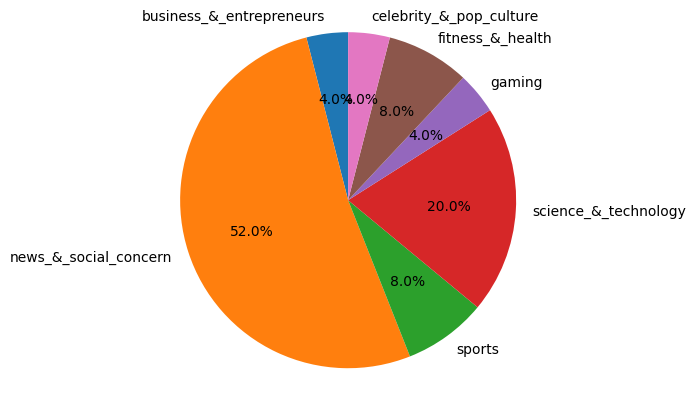

In [ ]:
print("Summary of today's news by topic:\n")

for i in range(len(aktualis_temak)):
  print(aktualis_temak[i], ":", temak_db[i], "db  (", round(temak_db[i]/osszeg*100, 1), "% )")

print("\n")

labels = aktualis_temak
sizes = temak_db

plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
plt.axis('equal')

plt.show()

Summary of today's news by feeling:

Positive: 1 db ( 5.0 % )
Negative: 5 db ( 25.0 % )
Neutral: 14 db ( 70.0 % ) 



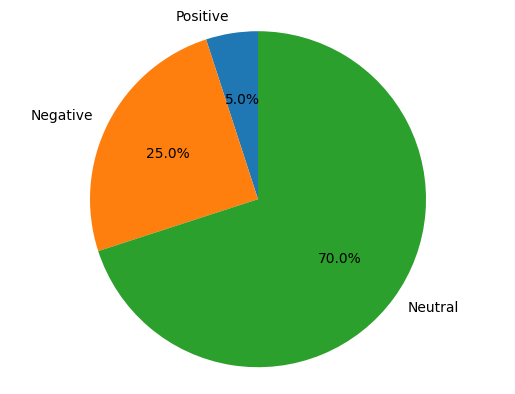

In [ ]:
print("Summary of today's news by feeling:\n")

print("Positive:", counter_positive, "db", "(", counter_positive/len(labelled_articles)*100, '%', ")")
print("Negative:", counter_negative, "db", "(", counter_negative/len(labelled_articles)*100, '%', ")")
print("Neutral:", counter_neutral, "db", "(", counter_neutral/len(labelled_articles)*100, '%', ")", "\n")

sizes = [counter_positive,
          counter_negative,
          counter_neutral]

labels = ["Positive",
          "Negative",
          "Neutral"]

plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
plt.axis('equal')

plt.show()

In [ ]:
atlag = 0
db = 0;
for i in range(len(labelled_articles)):
  szavak = labelled_articles[i].title.split(" ")
  atlag = atlag + len(szavak)
  db=db + 1
print("A címek szavainak átlaga: ", atlag/db)

A címek szavainak átlaga:  14.6


In [ ]:
szavak_dictionary = {}
for i in range(len(labelled_articles)):
  if(labelled_articles[i].description is not None):
    szavak = labelled_articles[i].description.split(" ")
    for j in range(len(szavak)):
      if szavak[j] in szavak_dictionary:
        szavak_dictionary[szavak[j]] = szavak_dictionary[szavak[j]] + 1
      else:
        szavak_dictionary[szavak[j]] = 1

Leggyakoribb szavak ábrázolása szófelhővel:



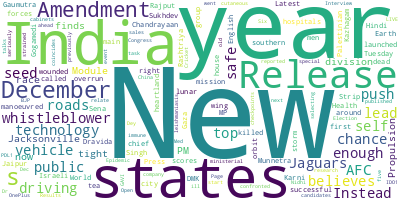

In [ ]:
print("Leggyakoribb szavak ábrázolása szófelhővel:\n")

wordcloud_szavak = WordCloud(background_color="white",
                      max_words=1000,
                      contour_width=3,
                      contour_color='steelblue')

wordcloud_szavak.generate(" ".join(szavak_dictionary))
wordcloud_szavak.to_image()

In [ ]:
sentiment_dictionary = {}
sentiment_dictionary["positive"] = counter_positive
sentiment_dictionary["negative"] = counter_negative
sentiment_dictionary["neutral"] = counter_neutral

Hangulatok ábrázolása szófelhővel:



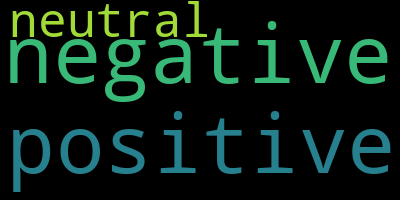

In [ ]:
print("Hangulatok ábrázolása szófelhővel:\n")
wordcloud_sentiments = WordCloud(background_color="black",
                      max_words=1000,
                      contour_width=3,
                      contour_color='steelblue')

wordcloud_sentiments.generate(" ".join(sentiment_dictionary))
wordcloud_sentiments.to_image()

# **Userrel való interakciók**

In [ ]:
print("Adjon meg egy témát, a következőkből választhat:\n")
for item in aktualis_temak:
  print("\t",item)

print("\nA választott téma: ")
tema = input()
print("\n")

b=False

for i in range(len(labelled_articles)):
    for j in range (len(labelled_articles[i].label)):
      if labelled_articles[i].label[j] == tema:
          print(labelled_articles[i].title)
          print(labelled_articles[i].description)
          print(labelled_articles[i].URL)
          print(labelled_articles[i].sentiment)
          print(labelled_articles[i].label)
          print()
          b=True

if(b==False):
  print("Érvénytelen téma")

Adjon meg egy témát, a következőkből választhat:

	 business_&_entrepreneurs
	 news_&_social_concern
	 sports
	 science_&_technology
	 gaming
	 fitness_&_health
	 celebrity_&_pop_culture

A választott téma: 
asd


Érvénytelen téma


In [ ]:
keyword = input("Kulcsszó: ")

b=False

for i in range(len(labelled_articles)):
  if keyword in labelled_articles[i].title:
    print(labelled_articles[i].title)
    print(labelled_articles[i].description)
    print(labelled_articles[i].URL)
    print(labelled_articles[i].sentiment)
    print(labelled_articles[i].label)
    print()
    b=True

if(b==False):
  print("Nincs megjeleníthető cikk")

Kulcsszó: asd
Nincs megjeleníthető cikk
